In [1]:
import numpy as np
from phi.torch.flow import *
from phi.physics._boundaries import Domain, STICKY as CLOSED
import random
import torch
import matplotlib.pyplot as plt

# Exercise 1
## a) Setup: 
Create a sufficiently large square periodic 2D domain and randomly distribute 1000 spheres within it. Let half of the
spheres have radius R = 1 and the other half radius R = 0.7. Visualize the resulting configuration for multiple seeds.
You can use $\Phi_{FLOW}$'s built in visualizations

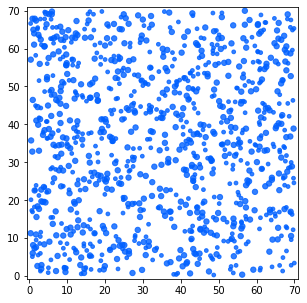

<Figure size 432x288 with 0 Axes>

In [2]:
np.random.seed(42)
# 1000 x 1000 grid, since 1000 balls and all balls have radii <= 1

width=70.0

n = 1000
R = 0.7



def get_points_random(n, width):
    return [(np.random.uniform(0,width), np.random.uniform(0,width)) for _ in range(n)]

def get_random_spheres(n, R=0.7, width=100.0):
    n_75 = n // 2
    n_1  = n - n_75
    radii = [1.0 for _ in range(n_1)] + [R for _ in range(n_75)]
    locations = get_points_random(n, width)
    locations_ = np.asarray(locations)
    locations = math.tensor(torch.tensor(locations) , instance('spheres'), channel('vector'))
    radii = math.tensor(torch.tensor(radii) , instance('radii'))
    return locations, radii
    
    
def rebase_locations_periodic(locations, width):
    return math.map(lambda x: x % width, locations)
    
locations, radii = get_random_spheres(n, R=R, width=width)

x = Sphere(locations, radius=radii)
vis.plot(x, lib="matplotlib")

# b) Energy Function
Before optimizing the sphere locations, we need to define a loss or energy function that penalizes overlapping spheres.
The value of the energy function should be 0 for spheres that do not overlap and should increase quadratically with
overlapping distance

Hint: To evaluate pairwise distances between the locations listed along the dimension ’spheres’ in x, use
dx = x - math.rename dims(x, ’spheres’, ’others’)
Hint: You can apply a transformation to dx in order to respect the periodic boundaries.

In [3]:
def energy_fkt(x, radii):
    dx = x - math.rename_dims(x, "spheres", "others")
    dx = math.l2_loss(dx, "vector")
    

    d_plus = math.abs(radii + math.rename_dims(radii, "radii", "others"))
    d_plus = math.rename_dims(d_plus, "radii", "spheres")
    d_plus = d_plus - math.tensor(2*np.diag(radii.numpy(order=["radii"])), instance("spheres", "others"))
    
    
    radii_stack = math.stack((radii for _ in range(n)), instance("spheres"))
    radii_stack = math.rename_dims(radii_stack, "radii", "others")
    dx = math.where(dx > d_plus, 0.0, math.abs(d_plus-dx)**2)
    return math.sum(dx)
    
energy_fkt(locations, radii)

2284.2388

## c) Gradient Descent Optimization
Write a gradient descent optimizer to minimize the energy function defined above. The optimizer should adjust the
sphere locations until none of them overlap (energy = 0). You can use math.functional_gradient() to compute the
gradients w.r.t. the locations. Plot the optimized configuration, ensuring all spheres lie within the domain!

Hint: The derivative of the sqrt function (required to compute the length of a vector) is infinite at 0. To avoid
NaN values in the optimization, this has to be avoided, e.g. with a lower cutoff or custom gradient or by avoiding the sqrt completely

/Users/davidwinderl/miniconda/envs/dl_physics/lib/python3.8/site-packages/phi/math/_tensors.py:851: UserWarning: dim.split() is deprecated. Use math.split_dims() instead.
  warnings.warn("dim.split() is deprecated. Use math.split_dims() instead.")


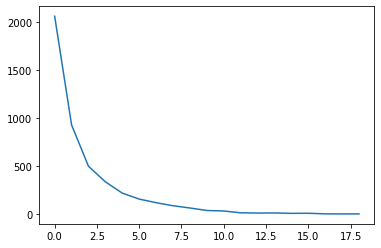

In [4]:
def loss_function(locations, width=70.0):
    locations = rebase_locations_periodic(locations, width)
    prediction = energy_fkt(locations, radii)
    return prediction



def solve_gradient_descent(n, R, width=70.0):
    gd_locations, radii = get_random_spheres(n, R=R, width=width)
    steps = 200
    lr = 0.1
    
    
    gradient = math.functional_gradient(loss_function, wrt=[0], get_output=True)
    
    losses = []
    for _ in range(steps):
        (loss, ), (grad,)  = gradient(gd_locations, width=width)
        gd_locations -= lr*grad
        losses.append(float(loss))
        if float(loss) < 0.1:
            break
        
    return losses, gd_locations
losses, gd_locations = solve_gradient_descent(n, R)
plt.plot(losses)
plt.show()

0.02480381354689598 19


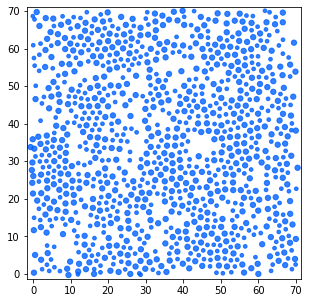

<Figure size 432x288 with 0 Axes>

In [5]:
print(losses[-1], len(losses))
x = Sphere(gd_locations, radius=radii)
vis.plot(x, lib="matplotlib")

## (d) Higher-order Optimization
The SciPy library provides a number of higher-order optimizers, such as ’L-BFGS-B’. These are available in ΦFlow via the minimize() function, e.g. `locations = math.minimize(energy function, Solve(’L-BFGS-B’, 0, 1e-5, max_iterations=2000, x0=initial_locations))`
Minimize the energy using a higher-order optimizer. How many iterations are needed compared to your gradient optimizer?

In [7]:
init_locations, radii = get_random_spheres(n, width=70.0)
solve_obj = Solve("L-BFGS-B", 0, 1e-5, max_iterations=2000, x0=init_locations)
nr_iterations = 0
with math.SolveTape() as solves:
    lbfgs_locations = math.minimize(loss_function, solve_obj)
    
    result: math.SolveInfo = solves[solve_obj]
    nr_iterations = result.iterations

In [8]:
print("Comparison to GD: ")
print("L-BFGS iterations: ", nr_iterations) 
print("L-BFGS loss:       ", loss_function(lbfgs_locations))
print("Gradient Descent Iterations: ", len(losses))
print("Gradient Descent loss: ", loss_function(gd_locations))

Comparison to GD: 
L-BFGS iterations:  15
L-BFGS loss:        2.6296368
Gradient Descent Iterations:  19
Gradient Descent loss:  0.0065063755


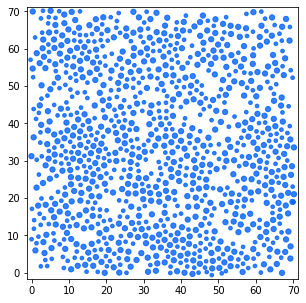

<Figure size 432x288 with 0 Axes>

In [9]:
x = Sphere(lbfgs_locations, radius=radii)
vis.plot(x, lib="matplotlib")

## (e) Smallest domain
Incrementally decrease the domain size until the loss cannot be reduced to below 0.01 anymore. How large is the
smallest domain that can contain all spheres without any overlaps? Repeat the experiment for multiple values of
$R \in (0, 1]$ and multiple initial configurations each. Plot the domain size against R, showing the standard deviation
across random configurations as error bars.

In [10]:
import pandas as pd
import seaborn as sns


import os.path
if os.path.exists("data.csv"):
    df = pd.read_csv("data.csv")
else:
    df = pd.DataFrame()
    for seed in [10, 42, 12, 13, 15]:
        for R in [1.0, 0.75, 0.5, 0.25, 0.1]:
            print(R, seed)
            np.random.seed(seed)
            last_loss = 0.0
            width = 70.0
            prev_width= None
            prev_gd_locs = None
            while True:
                prev_width = width
                width -= 10.0
                print(width)
                losses, gd_locations = solve_gradient_descent(n, R, width=width)
                print(losses[-1], len(losses))
                if losses[-1] > 0.1:
                    print(losses[-1])
                    break
                last_loss = losses[-1]
                prev_gd_locs = gd_locations
            if prev_gd_locs is not None:
                df = df.append({"width": prev_width, "R": R, "seed": seed}, ignore_index=True)
            else:
                print("Warning! No Results found")
            print("Results:\t ", "R: ", R, "width: ", width, "Last Loss: ", last_loss)

<AxesSubplot:xlabel='R', ylabel='width'>

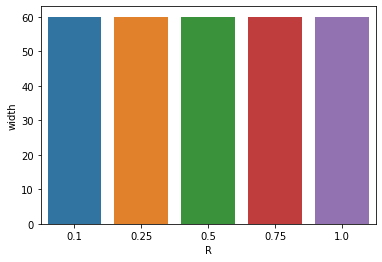

In [11]:
df
sns.barplot(x="R", y="width", data=df)


*Note:* For some reason I always converged at 60 without any errors or didn
't converge. Hence I assume this is the best I can do with the setup of lr and number of epochs.